<a href="https://colab.research.google.com/github/Sg0107/CNN/blob/main/Object_detection_and_bounding_boxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model
from drive.MyDrive.W3A1.Files.home.jovyan.work.W3A1.yad2k.models.keras_yolo import yolo_head
from drive.MyDrive.W3A1.Files.home.jovyan.work.W3A1.yad2k.utils.utils import get_colors_for_classes, scale_boxes, read_anchors, preprocess_image, read_classes

%matplotlib inline


In [7]:
def yolo_filter_boxes(boxes,box_confidence,box_class_probs,threshold=0.6):
  box_scores = box_confidence*box_class_probs
  box_classes = tf.math.argmax(box_scores,axis=-1)
  box_class_scores = tf.math.reduce_max(box_scores, axis=-1)
  filtering_mask = box_class_scores>=threshold
  scores = tf.boolean_mask(box_class_scores,filtering_mask)
  boxes = tf.boolean_mask(boxes,filtering_mask)
  classes = tf.boolean_mask(box_classes,filtering_mask)
  return scores,boxes,classes

In [8]:
def iou(box1,box2):
  (box1_x1,box1_y1,box1_x2,box1_y2) = box1
  (box2_x1,box2_y1,box2_x2,box2_y2) = box2
  xi1 = max(box1_x1,box2_x1)
  xi2 = min(box1_x2,box2_x2)
  yi1 = max(box1_y1,box2_y1)
  yi2 = min(box1_y2,box2_y2)
  width = max(xi2-xi1,0)
  height = max(yi2-yi1,0)
  area = max(height,0)*max(width,0)
  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-area
  iou = area/union_area
  return iou

In [9]:
def yolo_non_max_supression(scores,boxes,classes,max_boxes = 10,iou_threshold = 0.5):
  max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')
  nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
  scores = tf.gather(scores, nms_indices)
  boxes = tf.gather(boxes, nms_indices)
  classes = tf.gather(classes, nms_indices)
  return scores, boxes, classes

In [10]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [11]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
  box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
  boxes = yolo_boxes_to_corners(box_xy,box_wh)
  scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=.6)
  boxes = scale_boxes(boxes, image_shape)
  scores, boxes, classes = yolo_non_max_supression(scores, boxes, classes, max_boxes, iou_threshold)
  return scores, boxes, classes

In [2]:
class_names = read_classes("/content/drive/MyDrive/W3A1/Files/home/jovyan/work/W3A1/model_data/coco_classes.txt")
anchors = read_anchors("/content/drive/MyDrive/W3A1/Files/home/jovyan/work/W3A1/model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [3]:
yolo_model = load_model("/content/drive/MyDrive/W3A1/Files/home/jovyan/work/W3A1/model_data/", compile=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [4]:
def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    #image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))
    if not isinstance(image, PIL.Image.Image):
        print("Error: Input image is not an instance of PIL.Image.")
        return None
    font = ImageFont.truetype(
        font='/content/drive/MyDrive/W3A1/Files/home/jovyan/work/W3A1/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]

        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)


In [5]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.

    Arguments:
    image_file -- name of an image stored in the "images" folder.

    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes

    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes.
    """

    # Preprocess your image
    image, image_data = preprocess_image("/content/" + image_file, model_image_size = (608, 608))

    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "/content/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("/content/", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("/content/", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 1 boxes for /content/1.jpg
laptop 0.90 (253, 45) (622, 421)


<ipython-input-4-47f4744a0bca>:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)


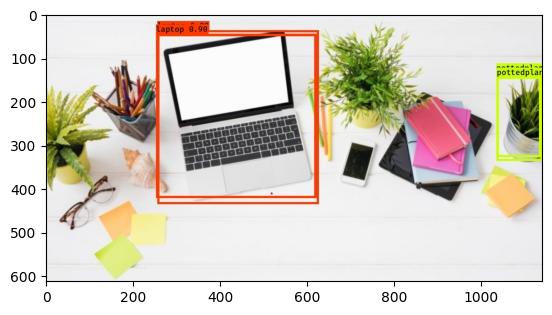

In [16]:
out_scores, out_boxes, out_classes = predict('1.jpg')

In [15]:
import os
import cv2

# Define the path to the folder containing the images
folder_path = '/content/drive/MyDrive/W3A1/Files/home/jovyan/work/W3A1/images/'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)
for i in range(120):
  a = file_list[i+1]
  out_scores, out_boxes, out_classes = predict(a)


FileNotFoundError: [Errno 2] No such file or directory: '/content/0016.jpg'